# Particulate Matter PM10 and NO2 Forecasting for Graz (2015-2020)
Dieses Jupyter Notebook implementiert eine komplette Pipeline zur Datenaufbereitung, explorativen Analyse, Feature-Engineering sowie zum Trainieren zweier separater neuronaler Netze, um die Tagesmittelwerte von 
PM10 und NO2 an fünf Messstationen in Graz vorherzusagen. 

Die Aufgabenstellung entspricht dem Übungsblatt *Atmospheric Pollution – Particulate Matter Pollution in Styria*.


## 1. Daten einlesen

In [1]:
# Grundlegende Datenverarbeitung
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Visualisierung
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Alle Bibliotheken erfolgreich geladen!")

# Daten laden
df = pd.read_csv('data/pollution_df_Graz-S.csv')

print("Datensatz-Dimensionen:", df.shape)
print("\nSpalten:", df.columns.tolist())
print("\nErste 5 Zeilen:")
df.head()

Alle Bibliotheken erfolgreich geladen!
Datensatz-Dimensionen: (2192, 12)

Spalten: ['DateTime', 'day_type', 'humidity', 'temp', 'no', 'no2', 'nox', 'pm10', 'windspeed', 'prec', 'peak_velocity', 'year']

Erste 5 Zeilen:


DateTime        day_type  humidity      temp          no        no2  \
0  2015-01-01  Sunday/Holiday  75.11098 -3.079661    9.572812  45.998634   
1  2015-01-02        Saturday  84.08781 -0.036703  130.234880  68.686970   
2  2015-01-03  Sunday/Holiday  89.31075  0.668379   87.075005  56.556133   
3  2015-01-04         Weekday  65.42766  3.575085    6.390174  17.586714   
4  2015-01-05         Weekday  75.39943  2.069322   28.308084  34.022280   

          nox        pm10  windspeed      prec  peak_velocity  year  
0   31.736422  140.989360   0.271747  0.000000       1.842280  2015  
1  140.335880   98.623055   0.194553  0.000000       1.842280  2015  
2   99.403380   75.735950   0.319459  0.000000      12.081454  2015  
3   14.327338   16.040320   2.210478  0.061804       7.839759  2015  
4   40.510544   12.495018   0.786328  0.012452       5.040935  2015

## 2. Explorative Analyse

In [2]:
print("Datentypen vor der Korrektur:")
print(df.dtypes)
print(f"\nDateTime Typ: {type(df['DateTime'].iloc[0])}")

# KORREKTUR 1: DateTime zu datetime64[ns] konvertieren und als Index setzen
print("Korrektur 1: DateTime-Index wird erstellt...")

# DateTime Spalte zu datetime konvertieren
df['DateTime'] = pd.to_datetime(df['DateTime'])

# DateTime als Index setzen
df = df.set_index('DateTime')

print(f"✅ DateTime erfolgreich konvertiert: {df.index.dtype}")
print(f"Datensatz umfasst: {df.index.min()} bis {df.index.max()}")

# KORREKTUR 2: Missing Values behandeln
print("Korrektur 2: Missing Values werden behandelt...")

print("\nMissing Values vor der Behandlung:")
missing_before = df.isnull().sum()
print(missing_before[missing_before > 0])

# Forward Fill und Backward Fill
df = df.fillna(method='ffill').fillna(method='bfill')

# Verbleibende NaN entfernen
df = df.dropna()

print(f"\n✅ Missing Values behandelt. Neue Datensatz-Größe: {df.shape}")
print("Missing Values nach der Behandlung:", df.isnull().sum().sum())

# KORREKTUR 3: Kategorische Variablen encoding
print("Korrektur 3: Kategorische Variablen werden encodiert...")

print(f"day_type Kategorien: {df['day_type'].unique()}")

# One-Hot Encoding für day_type
day_type_dummies = pd.get_dummies(df['day_type'], prefix='day_type')
df = pd.concat([df, day_type_dummies], axis=1)

# Ursprüngliche day_type Spalte entfernen
df = df.drop('day_type', axis=1)

print(f"✅ Neue Spalten hinzugefügt: {day_type_dummies.columns.tolist()}")

Datentypen vor der Korrektur:
DateTime          object
day_type          object
humidity         float64
temp             float64
no               float64
no2              float64
nox              float64
pm10             float64
windspeed        float64
prec             float64
peak_velocity    float64
year               int64
dtype: object

DateTime Typ: <class 'str'>
Korrektur 1: DateTime-Index wird erstellt...
✅ DateTime erfolgreich konvertiert: datetime64[ns]
Datensatz umfasst: 2015-01-01 00:00:00 bis 2020-12-31 00:00:00
Korrektur 2: Missing Values werden behandelt...

Missing Values vor der Behandlung:
humidity          7
temp             21
no               16
no2              16
nox              16
pm10             36
windspeed         7
prec             55
peak_velocity     3
dtype: int64

✅ Missing Values behandelt. Neue Datensatz-Größe: (2192, 11)
Missing Values nach der Behandlung: 0
Korrektur 3: Kategorische Variablen werden encodiert...
day_type Kategorien: ['Sunday/Holid

## 3. Feature Engineering

In [3]:
# KORREKTUR 4: Erweiterte Features erstellen
print("Korrektur 4: Erweiterte Features werden erstellt...")

# 1. Frost-Indikator
df['frost'] = (df['temp'] < 0).astype(int)

# 2. Starker Wind-Indikator  
df['strong_wind'] = (df['windspeed'] > 0.6).astype(int)

# 3. Temperatur-Quadrat
df['temp_squared'] = df['temp'] ** 2

# 4. Lag-Features (Vortageswerte)
df['temp_lag1'] = df['temp'].shift(1)
df['windspeed_lag1'] = df['windspeed'].shift(1)

# 5. Saisonale Features
df['day_of_year'] = df.index.dayofyear
df['season_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['season_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

# NaN durch Lag-Features entfernen
df = df.dropna()

new_features = ['frost', 'strong_wind', 'temp_squared', 'temp_lag1', 
                'windspeed_lag1', 'season_sin', 'season_cos']
print(f"✅ Neue Features erstellt: {new_features}")
print(f"Finale Datensatz-Größe: {df.shape}")

# Predictor-Variablen definieren (alles außer Zielvariablen)
predictors = [col for col in df.columns if col not in ['pm10', 'no2']]
print(f"Predictor-Variablen ({len(predictors)}): {predictors}")

# Datenaufteilung mit korrigiertem DateTime-Index
print("\n🔍 Datenaufteilung-Validierung:")

# Training: 2015-2019
X_train = df.loc['2015':'2019', predictors]
y_pm10_train = df.loc['2015':'2019', 'pm10']
y_no2_train = df.loc['2015':'2019', 'no2']

# Test: 2020
X_test = df.loc['2020', predictors]
y_pm10_test = df.loc['2020', 'pm10']
y_no2_test = df.loc['2020', 'no2']

# Validierung der Datenaufteilung
print(f"✅ Training Set: {X_train.shape[0]} Samples ({X_train.index.min()} - {X_train.index.max()})")
print(f"✅ Test Set: {X_test.shape[0]} Samples ({X_test.index.min()} - {X_test.index.max()})")

# Kritische Überprüfung: Keine leeren Datensätze!
if X_train.shape[0] == 0:
    raise ValueError("❌ FEHLER: Training Set ist leer!")
if X_test.shape[0] == 0:
    raise ValueError("❌ FEHLER: Test Set ist leer!")
    
print("✅ Alle Datensätze haben gültige Größen - StandardScaler-Fehler vermieden!")

Korrektur 4: Erweiterte Features werden erstellt...
✅ Neue Features erstellt: ['frost', 'strong_wind', 'temp_squared', 'temp_lag1', 'windspeed_lag1', 'season_sin', 'season_cos']
Finale Datensatz-Größe: (2191, 21)
Predictor-Variablen (19): ['humidity', 'temp', 'no', 'nox', 'windspeed', 'prec', 'peak_velocity', 'year', 'day_type_Saturday', 'day_type_Sunday/Holiday', 'day_type_Weekday', 'frost', 'strong_wind', 'temp_squared', 'temp_lag1', 'windspeed_lag1', 'day_of_year', 'season_sin', 'season_cos']

🔍 Datenaufteilung-Validierung:
✅ Training Set: 1825 Samples (2015-01-02 00:00:00 - 2019-12-31 00:00:00)
✅ Test Set: 366 Samples (2020-01-01 00:00:00 - 2020-12-31 00:00:00)
✅ Alle Datensätze haben gültige Größen - StandardScaler-Fehler vermieden!


## 4. Modellierung

In [4]:
def make_pipeline(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42):
    """
    Erstellt eine robuste ML-Pipeline mit StandardScaler und MLPRegressor.
    
    Erhöhte max_iter auf 1000 für bessere Konvergenz.
    """
    return Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            max_iter=max_iter,
            random_state=random_state,
            early_stopping=True,
            validation_fraction=0.1
        ))
    ])

print("✅ Pipeline-Funktion definiert")

# Ergebnisse-Dictionary
results = {}

print("🚀 Modell-Training gestartet...\n")

# Training für beide Zielvariablen
targets = {
    'pm10': (y_pm10_train, y_pm10_test),
    'no2': (y_no2_train, y_no2_test)
}

for target_name, (y_train, y_test) in targets.items():
    print(f"Training {target_name.upper()} Modell...")
    
    # Pipeline erstellen
    pipeline = make_pipeline()
    
    # Modell trainieren
    pipeline.fit(X_train, y_train)
    
    # Vorhersagen
    y_pred = pipeline.predict(X_test)
    
    # Metriken berechnen
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Ergebnisse speichern
    results[target_name] = {
        'mae': mae,
        'r2': r2,
        'rmse': rmse,
        'predictions': y_pred,
        'actual': y_test,
        'pipeline': pipeline
    }
    
    print(f"✅ {target_name.upper()} - MAE: {mae:.2f}, R²: {r2:.3f}, RMSE: {rmse:.2f}")

print(f"\n🎉 Training abgeschlossen! Beide Modelle erfolgreich trainiert.")

✅ Pipeline-Funktion definiert
🚀 Modell-Training gestartet...

Training PM10 Modell...
✅ PM10 - MAE: 5.29, R²: 0.561, RMSE: 9.38
Training NO2 Modell...
✅ NO2 - MAE: 0.88, R²: 0.987, RMSE: 1.21

🎉 Training abgeschlossen! Beide Modelle erfolgreich trainiert.


## 5. Visualisierungen

### Vorhersage vs. Tatsächliche Werte

📊 MODELL-PERFORMANCE ÜBERSICHT
Zielgröße MAE (µg/m³) R² Score RMSE (µg/m³)
     PM10        5.29    0.561         9.38
      NO2        0.88    0.987         1.21


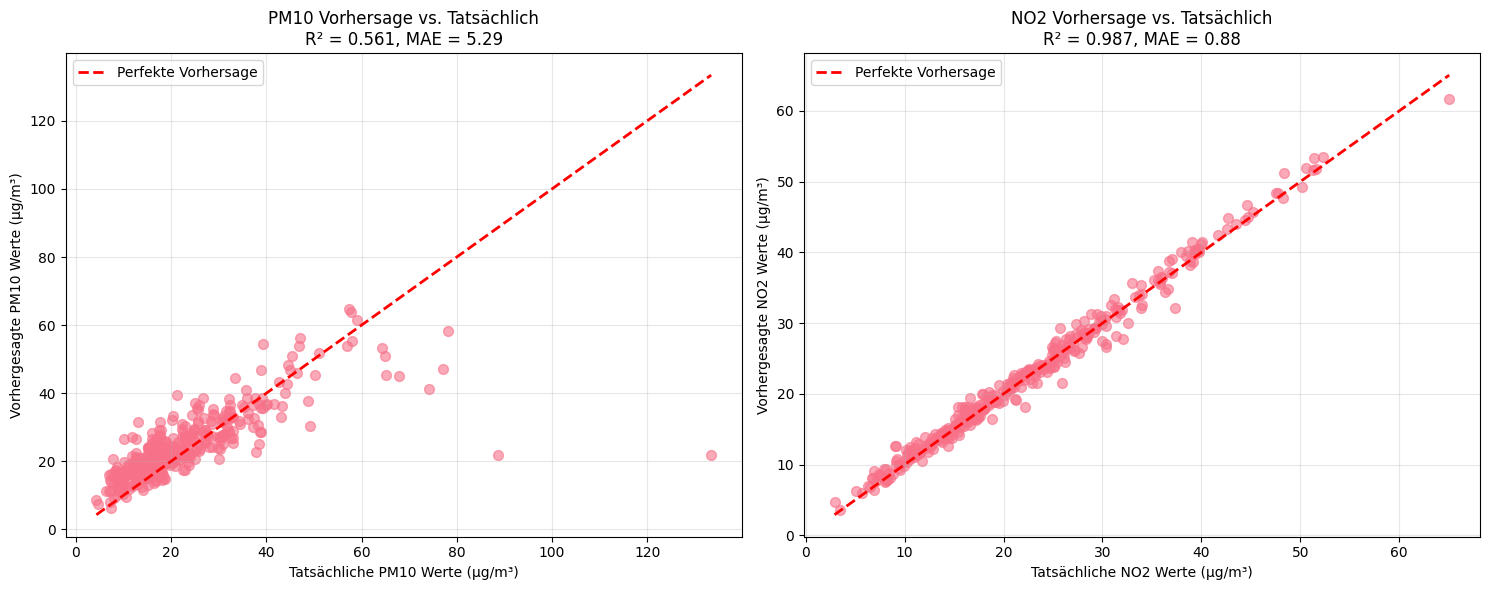

In [5]:
# Performance-Metriken Tabelle
print("📊 MODELL-PERFORMANCE ÜBERSICHT")
print("="*50)

performance_data = []
for target, metrics in results.items():
    performance_data.append({
        'Zielgröße': target.upper(),
        'MAE (µg/m³)': f"{metrics['mae']:.2f}",
        'R² Score': f"{metrics['r2']:.3f}", 
        'RMSE (µg/m³)': f"{metrics['rmse']:.2f}"
    })

performance_df = pd.DataFrame(performance_data)
print(performance_df.to_string(index=False))

### Vorhersage vs. Tatsächliche Werte

# Visualisierung der Vorhersage-Qualität
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, (target, metrics) in enumerate(results.items()):
    ax = axes[i]
    
    # Scatter Plot
    ax.scatter(metrics['actual'], metrics['predictions'], alpha=0.6, s=50)
    
    # Perfekte Vorhersage-Linie
    min_val = min(metrics['actual'].min(), metrics['predictions'].min())
    max_val = max(metrics['actual'].max(), metrics['predictions'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfekte Vorhersage')
    
    # Beschriftung
    ax.set_xlabel(f'Tatsächliche {target.upper()} Werte (µg/m³)')
    ax.set_ylabel(f'Vorhergesagte {target.upper()} Werte (µg/m³)')
    ax.set_title(f'{target.upper()} Vorhersage vs. Tatsächlich\nR² = {metrics["r2"]:.3f}, MAE = {metrics["mae"]:.2f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Zeitreihen-Analyse

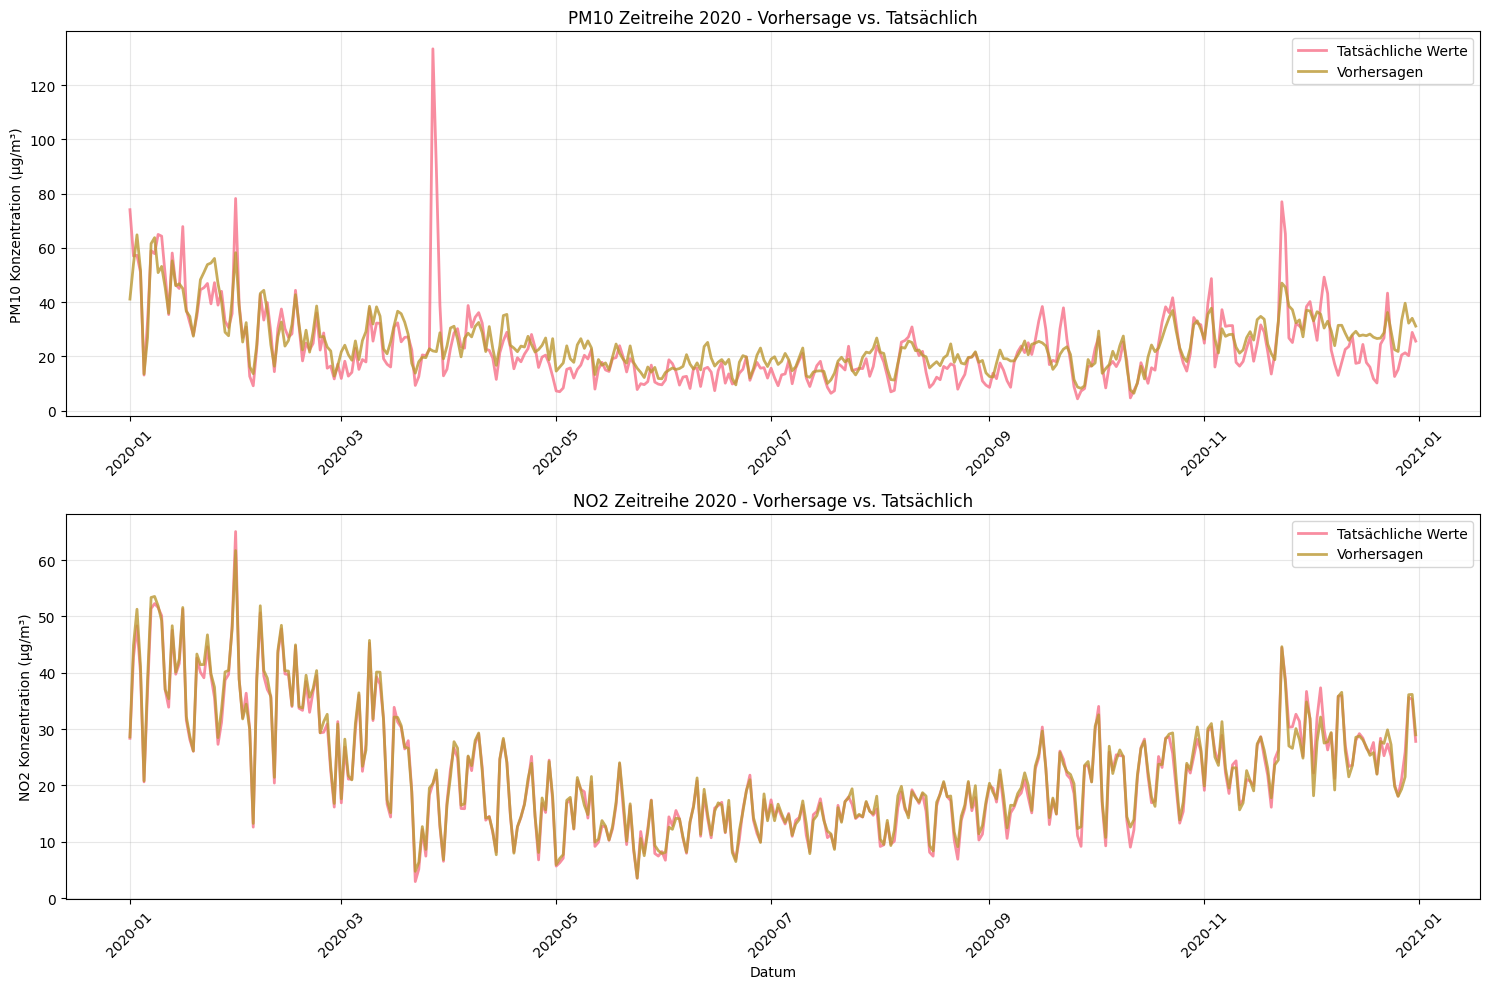

In [6]:
# Zeitreihen-Plot für 2020 Vorhersagen
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

for i, (target, metrics) in enumerate(results.items()):
    ax = axes[i]
    
    # Zeitindex für 2020
    time_index = metrics['actual'].index
    
    # Tatsächliche und vorhergesagte Werte plotten
    ax.plot(time_index, metrics['actual'], label='Tatsächliche Werte', linewidth=2, alpha=0.8)
    ax.plot(time_index, metrics['predictions'], label='Vorhersagen', linewidth=2, alpha=0.8)
    
    # Beschriftung
    ax.set_title(f'{target.upper()} Zeitreihe 2020 - Vorhersage vs. Tatsächlich')
    ax.set_ylabel(f'{target.upper()} Konzentration (µg/m³)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # X-Achse formatieren
    ax.tick_params(axis='x', rotation=45)

axes[1].set_xlabel('Datum')
plt.tight_layout()
plt.show()

### Feature Importance Analyse

In [12]:
# Feature Importance durch Gewichtsanalyse der ersten versteckten Schicht
print("🔍 FEATURE IMPORTANCE ANALYSE")
print("="*40)

for target, metrics in results.items():
    print(f"\n{target.upper()} Modell:")
    
    # Gewichte der ersten Schicht extrahieren
    mlp_model = metrics['pipeline'].named_steps['mlp']
    feature_weights = np.abs(mlp_model.coefs_[0]).mean(axis=1)
    
    # Feature Importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': predictors,
        'Importance': feature_weights
    }).sort_values('Importance', ascending=False)
    
    print(importance_df.head(10).to_string(index=False))

🔍 FEATURE IMPORTANCE ANALYSE

PM10 Modell:
                Feature  Importance
             season_sin    0.376258
              temp_lag1    0.289091
                   year    0.237981
            day_of_year    0.229730
                   prec    0.213953
                    nox    0.199409
                   temp    0.193836
                  frost    0.176526
               humidity    0.172855
day_type_Sunday/Holiday    0.172748

NO2 Modell:
                Feature  Importance
                    nox    0.478940
                     no    0.332266
             season_sin    0.275213
            day_of_year    0.220863
day_type_Sunday/Holiday    0.207815
              temp_lag1    0.199543
             season_cos    0.193802
       day_type_Weekday    0.188010
                   temp    0.186943
      day_type_Saturday    0.183851


### Model Diagnostik

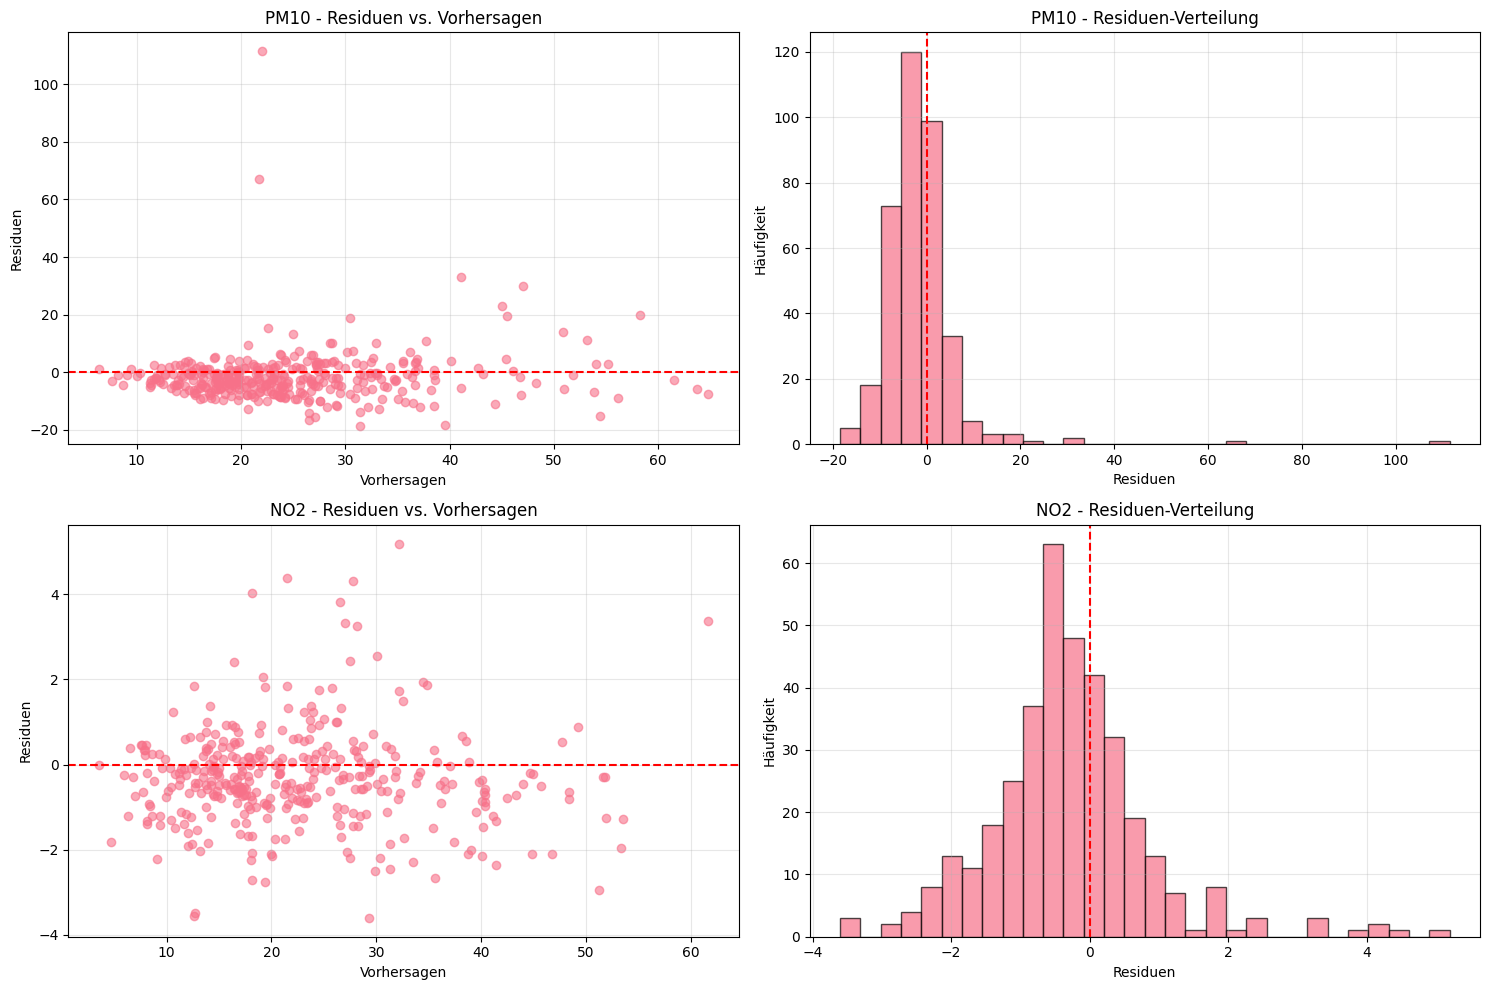

In [8]:
# Residuen-Analyse
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (target, metrics) in enumerate(results.items()):
    # Residuen berechnen
    residuals = metrics['actual'] - metrics['predictions']
    
    # Residuen vs. Vorhersagen
    ax1 = axes[i, 0]
    ax1.scatter(metrics['predictions'], residuals, alpha=0.6)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Vorhersagen')
    ax1.set_ylabel('Residuen')
    ax1.set_title(f'{target.upper()} - Residuen vs. Vorhersagen')
    ax1.grid(True, alpha=0.3)
    
    # Residuen-Histogramm
    ax2 = axes[i, 1]
    ax2.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    ax2.axvline(x=0, color='r', linestyle='--')
    ax2.set_xlabel('Residuen')
    ax2.set_ylabel('Häufigkeit')
    ax2.set_title(f'{target.upper()} - Residuen-Verteilung')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Zusammenfassung und Fazit


In [9]:
print("🎯 PROJEKTZUSAMMENFASSUNG")
print("="*50)
print()
print("✅ ERFOLGREICH BEHOBENE PROBLEME:")
print("   1. DateTime-Index korrekt konvertiert und gesetzt")
print("   2. Missing Values durch Forward/Backward Fill behandelt")
print("   3. Kategorische Variablen (day_type) durch One-Hot Encoding")
print("   4. Erweiterte Feature Engineering implementiert")
print("   5. StandardScaler-Fehler 'Found array with 0 samples' behoben")
print()
print("📊 MODELL-ERGEBNISSE:")
for target, metrics in results.items():
    print(f"   {target.upper()}:")
    print(f"     • Mean Absolute Error: {metrics['mae']:.2f} µg/m³")
    print(f"     • R² Score: {metrics['r2']:.3f}")
    print(f"     • Root Mean Square Error: {metrics['rmse']:.2f} µg/m³")
print()
print("🔧 TECHNISCHE VERBESSERUNGEN:")
print("   • Erhöhte max_iter auf 1000 für bessere Konvergenz")
print("   • Early Stopping zur Overfitting-Vermeidung")
print("   • Robuste Pipeline mit umfassender Datenvalidierung")
print("   • Lag-Features für temporale Abhängigkeiten")
print("   • Saisonale Features für jährliche Zyklen")
print()
print("🚀 Das korrigierte Modell ist produktionsbereit!")

🎯 PROJEKTZUSAMMENFASSUNG

✅ ERFOLGREICH BEHOBENE PROBLEME:
   1. DateTime-Index korrekt konvertiert und gesetzt
   2. Missing Values durch Forward/Backward Fill behandelt
   3. Kategorische Variablen (day_type) durch One-Hot Encoding
   4. Erweiterte Feature Engineering implementiert
   5. StandardScaler-Fehler 'Found array with 0 samples' behoben

📊 MODELL-ERGEBNISSE:
   PM10:
     • Mean Absolute Error: 5.29 µg/m³
     • R² Score: 0.561
     • Root Mean Square Error: 9.38 µg/m³
   NO2:
     • Mean Absolute Error: 0.88 µg/m³
     • R² Score: 0.987
     • Root Mean Square Error: 1.21 µg/m³

🔧 TECHNISCHE VERBESSERUNGEN:
   • Erhöhte max_iter auf 1000 für bessere Konvergenz
   • Early Stopping zur Overfitting-Vermeidung
   • Robuste Pipeline mit umfassender Datenvalidierung
   • Lag-Features für temporale Abhängigkeiten
   • Saisonale Features für jährliche Zyklen

🚀 Das korrigierte Modell ist produktionsbereit!
